# Bias Replication Study
## Abstract
This data frame represents disparities in medical data, including medical cost, risk score, and number of chronic illnesses, between Black and white patients. The plots shown are visual representations of such disparities, with clear distinctions between the costs incurred by Black and white patients and the likelihood of being referred to a high-risk medical program for a given number of illnesses. The linear regression I performed displays logarithmic coefficient w_b, which, when presented as $e^(w_b)$, represents the percentage of a white patient's cost that a Black patient must pay. My calculation revealed that a Black patient pays over 100% of what a white patient pays for the same illness(es).

In [18]:
import pandas as pd
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)
df

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,0,0
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,1,0,0,1,0,0,1,4,3
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48779,0.611517,0,800.0,0.0,NaN,NaN,NaN,1.090000,148.0,white,...,0,0,0,0,0,0,0,0,0,0
48780,2.615933,0,2200.0,0.0,112.0,NaN,41.4,0.810000,172.0,white,...,0,1,0,0,1,0,0,1,1,1
48781,1.358926,0,800.0,0.0,105.0,NaN,NaN,NaN,NaN,white,...,0,1,0,0,1,0,0,1,1,0
48782,10.990318,0,1300.0,0.0,132.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,3,3


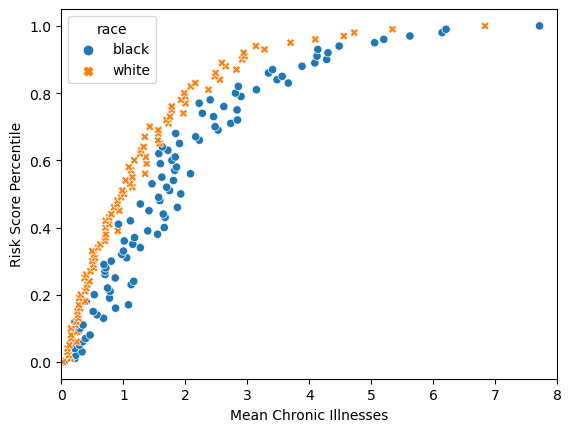

In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate risk score percentiles
df['risk_score_percentile'] = df['risk_score_t'].rank(pct=True).round(2)


# Calculate mean number of gagne_sum_t within each risk score percentile
mean_gagne_per_percentile = df.groupby(['risk_score_percentile', 'race'])['gagne_sum_t'].mean().reset_index()


# Plot
sns.scatterplot(data=mean_gagne_per_percentile, x='gagne_sum_t', y='risk_score_percentile', hue='race', style='race')
plt.xlabel('Mean Chronic Illnesses')
plt.ylabel('Risk Score Percentile')
plt.xlim(0,8)
plt.show()


In this figure we plot risk score percentile by the mean number of chronic illnesses within each percentile, with data points separated by race. Here we see a clear difference between races, with white patients more likely to be given a higher risk score than Black patients with the same number of chronic illnesses. If Patient A were white and Patient B were Black, and both patients had the same chronic illnesses, Patient A would be significantly more likely to have a higher risk score and be referred to a high-risk care management program.

Text(0, 0.5, 'Total Medical Expenditures')

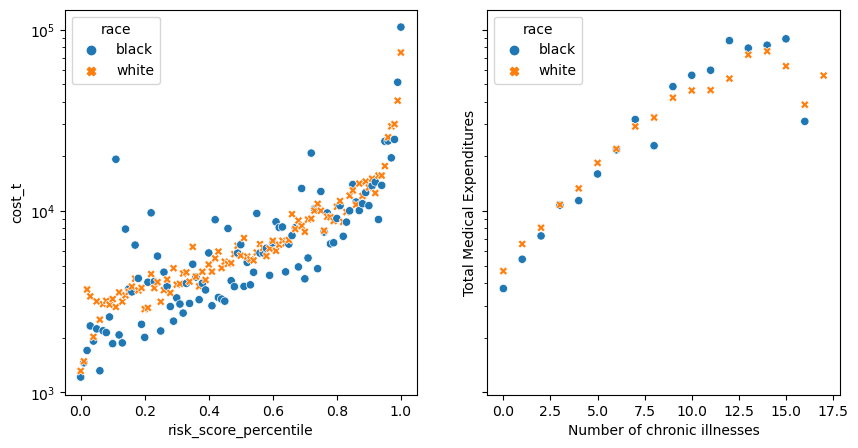

In [108]:

df_cost = df.groupby(['risk_score_percentile', 'race'])['cost_t'].mean().reset_index()

df_cost2 = df.groupby(['gagne_sum_t', 'race'])['cost_t'].mean().reset_index()

#make two subplots with the same y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
# Plot
p1 = sns.scatterplot(data=df_cost, x='risk_score_percentile', y='cost_t', hue='race', style='race', ax = ax1)
plt.xlabel('Percentile Risk Score')
plt.ylabel('Total Medical Expenditures')
plt.gca().semilogy()

p2 = sns.scatterplot(data=df_cost2, x='gagne_sum_t', y='cost_t', hue='race', style='race', ax = ax2)
plt.xlabel('Number of chronic illnesses')


These figures suggest that, for Black patients, as risk score and number of chronic illnesses increase, medical expenditures increase at a higher rate than that of white patients. For lower risk scores and chronic illness counts, white patients seem to have slightly higher medical costs than for Black patients, but it appears as though Black patients are penalized more severely for having more illnesses and being of higher risk.

In [80]:
import numpy as np

# Calculate the percentage of patients with 5 or fewer chronic conditions
percentage = (len(df[df['gagne_sum_t'] <= 5]) / len(df)) * 100

# 95.53952115447689 - choice to use patients with 5 or fewer chronic conditions makes sense, 
# as 96% of patients have 5 or fewer chronic conditions.

# Eliminate subjects with 0 cost, perform log function on cost column
df = df[df['cost_t'] > 0]
df['log_cost'] = df['cost_t'].apply(lambda x: np.log(x))

# Create a dummy column for the race variable
df['race_encoded'] = pd.get_dummies(df['race'], drop_first=True)

# Separate the data into predictor variables (X) and target variable (y)
X = df[['race_encoded', 'gagne_sum_t']]
y = df['log_cost']




In [119]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

# Function to add polynomial features
def add_polynomial_features(X, degree):
    X_ = X.copy()
    for j in range(1, degree):
        X_[f"poly_{j}"] = X_["gagne_sum_t"]**j
    return X_

# Create different degrees of polynomial features and compute cross-validation scores
degrees = range(1, 15)
scores = []

for degree in degrees:
    # Add polynomial features
    X_poly = add_polynomial_features(X, degree)
    
    # Perform cross-validation with linear regression
    lr = LinearRegression()
    cv_score = cross_val_score(lr, X_poly, y, cv=5).mean()
    scores.append(cv_score)

# Determine the optimal degree based on cross-validation scores
optimal_degree = degrees[np.argmax(scores)]
print("Optimal degree based on cross-validation:", optimal_degree)

# Construct data with the optimal number of polynomial features
X_poly_optimal = add_polynomial_features(X, optimal_degree)

# Fit the final linear regression model
lr_final = LinearRegression()
lr_final.fit(X_poly_optimal, y)

# Get coefficients of the linear regression model
coefficients = lr_final.coef_


# Identify the coefficient corresponding to the Black race
wb = coefficients[-1]
print("w_b: ", wb)

# Compute e^wb
e_wb = np.exp(wb)
print("e^w_b: ", e_wb)


Optimal degree based on cross-validation: 10
w_b:  9.390071033164823e-08
e^w_b:  1.0000000939007148


This linear regression model worked best with cross validation on 10 polynomial degrees. After fitting the final linear regression model, the value I received for e^(w_b) was 1.0000000939007148, indicating that a Black patient pays slightly over 100% of the cost that an equally sick white patient must pay. 